In [6]:
import pandas as pd

data_train = pd.read_csv('adult_train.csv')

Xtrain, Ytrain = data_train.iloc[:, :-1], data_train.iloc[:, -1]

data_test = pd.read_csv('adult_test.csv')

Xtest, Ytest = data_test.iloc[:, :-1], data_test.iloc[:, -1]


In [30]:
from sklearn.feature_extraction import DictVectorizer


train_dicts = Xtrain.to_dict('records')
test_dicts = Xtest.to_dict('records')
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(train_dicts)
X_test_encoded = dv.transform(test_dicts)




In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = DecisionTreeClassifier(max_depth=3)
scores = cross_val_score(clf, X_train_encoded, Ytrain)
scores.mean()

0.8437702604618773

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
  
pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(train_dicts, Ytrain)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [32]:
scores = cross_val_score(pipeline, train_dicts, Ytrain)
scores.mean()

0.8437702604618773

**Task 2**


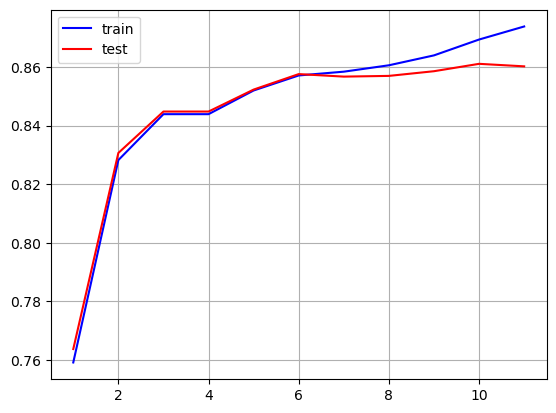

In [36]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

pred_test_values = []
pred_train_values = []
for max_depth in range(1, 12):
    pipeline = make_pipeline(
        DictVectorizer(),
        DecisionTreeClassifier(max_depth=max_depth)
        )

    pipeline.fit(train_dicts, Ytrain)

    pred_train_values.append(accuracy_score(Ytrain, pipeline.predict(train_dicts)))
    pred_test_values.append(accuracy_score(Ytest, pipeline.predict(test_dicts)))

x = range(1, 12)
plt.plot(x, pred_train_values, 'b', label='train')
plt.plot(x, pred_test_values, 'r', label='test')
plt.grid('True')
plt.legend()

**Underfitting and overfitting in decision tree classifiers.**

We see that the test and train accuracy diverge when the max depth gets large, which is similar to what we got in the previous assignment (task 4 step 4).